# Linear Regression

## Summary

- Introduction
- Analytical approach: normal equation
- Iterative approach: gradient descent
- Polynomial regression
- Regularization

## Introduction

### Linear regression in a nutshell

A linear regression model searches for a linear relationship between inputs (features) and output (target).

[![Linear Regression example](https://github.com/bpesquet/mlhandbook/blob/master/algorithms/images/linear_regression.png?raw=1)](https://en.wikipedia.org/wiki/Linear_regression)

### Problem formulation

A linear model makes a prediction by computing a weighted sum of the input features, plus a constant term called *bias* (or sometimes *intercept*).

$$y' = \theta_0 + \theta_1x_1 + \dotsc + \theta_nx_n$$

- $y'$ is the model's output (prediction).
- $n$ is the number of features for a data sample.
- $x_i, i \in [1..n]$ is the value of the $i$th feature.
- $\theta_i, i \in [0..n]$ is $i$th model parameter. $\theta_0$ is the bias term.

The goal is to find the best set of parameters.

### Example: using a linear model to predict country happiness

(Inspired by [Homemade Machine Learning](https://github.com/trekhleb/homemade-machine-learning) by Oleksii Trekhleb)

The [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness#2017.csv) ranks 155 countries by their happiness levels. Several economic and social indicators (GDP, degree of freedom, level of corruption...) are recorded for each country.

Can a linear model accurately predict country happiness based on these indicators ?

### Environment setup

In [3]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import pandas as pd

Python version: 3.8.3


ModuleNotFoundError: No module named 'plotly'

In [4]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = "retina"
sns.set()

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

NameError: name 'plotly' is not defined

In [5]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

scikit-learn version: 0.23.1


### Data loading and analysis

In [6]:
# Load World Happiness Report for 2017
dataset_url = "https://raw.githubusercontent.com/bpesquet/mlhandbook/master/_datasets/world-happiness-report-2017.csv"
df_happiness = pd.read_csv(dataset_url)

# Print dataset shape (rows and columns)
print(f"Dataset shape: {df_happiness.shape}")

NameError: name 'pd' is not defined

In [ ]:
# Print a concise summary of the dataset
df_happiness.info()

In [ ]:
# Show the 10 first samples
df_happiness.head(n=10)

In [ ]:
# Plot histograms for all numerical attributes
df_happiness.hist(bins=20, figsize=(16, 12))
plt.show()

### Univariate regression

Only one feature is used by the model, which has two parameters.

$$y' = \theta_0 + \theta_1x$$

### Example: predict country happiness using only GDP

In [ ]:
def filter_dataset(df_data, input_features, target_feature):
    """Return a dataset containing only the selected input and output features"""
    
    feature_list = input_features + [target_feature]
    return df_data[feature_list]

In [ ]:
# Define GDP as sole input feature
input_features_uni = ["Economy..GDP.per.Capita."]
# Define country happiness as target
target_feature = "Happiness.Score"

df_happiness_uni = filter_dataset(df_happiness, input_features_uni, target_feature)

In [ ]:
# Show 10 random samples
df_happiness_uni.sample(n=10)

### Data splitting

In [ ]:
def split_dataset(df_data, input_features, target_feature):
    """Split dataset between training and test sets, keeping only selected features"""
    
    df_train, df_test = train_test_split(df_data, test_size=0.2)

    print(f"Training dataset: {df_train.shape}")
    print(f"Test dataset: {df_test.shape}")

    x_train = df_train[input_features].to_numpy()
    y_train = df_train[target_feature].to_numpy()

    x_test = df_test[input_features].to_numpy()
    y_test = df_test[target_feature].to_numpy()

    print(f"Training data: {x_train.shape}, labels: {y_train.shape}")
    print(f"Test data: {x_test.shape}, labels: {y_test.shape}")

    return x_train, y_train, x_test, y_test

In [ ]:
x_train_uni, y_train_uni, x_test_uni, y_test_uni = split_dataset(
    df_happiness_uni, input_features_uni, target_feature
)

### Data plotting

In [ ]:
def plot_univariate(x, y, input_features, target_features, model_list=None):
    """2D plot of features and target, including model prediction if defined"""

    plt.scatter(x, y, label="Actual")

    if model_list is not None:
        predictions_count = 100
        x_pred = np.linspace(x.min(), x.max(), predictions_count).reshape(
            predictions_count, 1
        )
        for model_name, model in model_list.items():
            y_pred = model.predict(x_pred)
            plt.plot(x_pred, y_pred, "r", label=model_name)

    plt.xlabel(input_features)
    plt.ylabel(target_feature)
    plt.title("Countries Happiness")
    plt.legend()

In [ ]:
# Plot training data
plot_univariate(x_train_uni, y_train_uni, input_features_uni, target_feature)

## Analytical approach: normal equation

### Problem formulation

- $\pmb{x}^{(i)}$: $i$th data sample, vector of $n+1$ features $x^{(i)}_j$ with $x^{(i)}_0 = 1$.
- $\pmb{\theta}$: parameters of the linear model, vector of $n+1$ values $\theta_j$.
- $\mathcal{h}_\theta$: hypothesis function (relationship between inputs and targets).
- $y'^{(i)}$: model output for the $i$th sample.

$$\pmb{x}^{(i)} = \begin{pmatrix}
       \ x^{(i)}_0 \\
       \ x^{(i)}_1 \\
       \ \vdots \\
       \ x^{(i)}_n
     \end{pmatrix} \in \pmb{R}^{n+1}
\;\;\;
\pmb{\theta} = \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix} \in \pmb{R}^{n+1}$$

$$y'^{(i)} = \mathcal{h}_\theta(x^{(i)}) = \theta_0 + \theta_1x^{(i)}_1 + \dotsc + \theta_nx^{(i)}_n = \pmb{\theta}^T\pmb{x}^{(i)}$$

### Loss function

We use the *Mean Squared Error* (MSE). RMSE is also a possible choice.

$$\mathcal{L}(\pmb{\theta}) = \frac{1}{m}\sum_{i=1}^m (y'^{(i)} - y^{(i)})^2 = \frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(x^{(i)}) - y^{(i)})^2$$

### Analytical solution

- Technique for computing the regression coefficients $\theta_i$ analytically (by calculus).
- One-step learning algorithm (no iterations).
- Also called *Ordinary Least Squares*.

$$\pmb{\theta^{*}} = (\pmb{X}^T\pmb{X})^{-1}\pmb{X}^T\pmb{y}$$

- $\pmb{\theta^*}$ is the parameter vector that minimizes the loss function $\mathcal{L}(\theta)$.
- This result is called the **Normal Equation**.

### Math proof (optional)

(Inspired by [Derivation of the Normal Equation for linear regression](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/) and [ML From Scratch, Part 1: Linear Regression](http://www.oranlooney.com/post/ml-from-scratch-part-1-linear-regression/))

#### Vectorized notation

- $\pmb{X}$: matrix of input data (*design matrix*). Each line corresponds to a sample.
- $\pmb{y}$: vector of target values.

$$\pmb{X} = \begin{bmatrix}
       \ x^{(0)T} \\
       \ x^{(1)T} \\
       \ \vdots \\
       \ x^{(m)T} \\
     \end{bmatrix} =
\begin{bmatrix}
       \ x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_n \\
       \ x^{(2)}_0 & x^{(2)}_1 & \cdots & x^{(2)}_n \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(m)}_0 & x^{(m)}_1 & \cdots & x^{(m)}_n
     \end{bmatrix}\;\;\;
\pmb{y} = \begin{pmatrix}
       \ y^{(1)} \\
       \ y^{(2)} \\
       \ \vdots \\
       \ y^{(m)}
     \end{pmatrix}$$
     
$$\pmb{X}\pmb{\theta} =
\begin{pmatrix}
       \ \theta_0 + \theta_1x^{(1)}_1 + \dotsc + \theta_nx^{(1)}_n \\
       \ \theta_0 + \theta_1x^{(2)}_1 + \dotsc + \theta_nx^{(2)}_n \\
       \ \vdots \\
       \ \theta_0 + \theta_1x^{(m)}_1 + \dotsc + \theta_nx^{(m)}_n
     \end{pmatrix} = 
\begin{pmatrix}
       \ \mathcal{h}_\theta(x^{(1)}) \\
       \ \mathcal{h}_\theta(x^{(2)}) \\
       \ \vdots \\
       \ \mathcal{h}_\theta(x^{(m)})
     \end{pmatrix}$$

#### Vectorized loss

The loss can also be expressed using a vectorized notation.

$$\mathcal{L}(\theta) = \frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(x^{(i)}) - y^{(i)})^2 = \frac{1}{m}{{\lVert{\pmb{X}\pmb{\theta} - \pmb{y}}\rVert}_2}^2$$

The squared norm of a vector $\pmb{v}$ is the inner product of that vector with its transpose: $\sum_{i=1}^n v_i^2 = \pmb{v}^T \pmb{v}$.

$$\mathcal{L}(\theta) = \frac{1}{m}(\pmb{X}\pmb{\theta} - \pmb{y})^T(\pmb{X}\pmb{\theta} - \pmb{y})$$

The previous expression can be developped.

$$\mathcal{L}(\theta) = \frac{1}{m}\left((\pmb{X}\pmb{\theta})^T - \pmb{y}^T)(\pmb{X}\pmb{\theta} - \pmb{y}\right) = \frac{1}{m}\left((\pmb{X}\pmb{\theta})^T\pmb{X}\pmb{\theta} - (\pmb{X}\pmb{\theta})^T\pmb{y} - \pmb{y}^T(\pmb{X}\pmb{\theta}) + \pmb{y}^T\pmb{y}\right)$$

Since $\pmb{X}\pmb{\theta}$ and $\pmb{y}$ are vectors, $(\pmb{X}\pmb{\theta})^T\pmb{y} = \pmb{y}^T(\pmb{X}\pmb{\theta})$.

$$\mathcal{L}(\theta) = \frac{1}{m}\left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} - 2(\pmb{X}\pmb{\theta})^T\pmb{y} + \pmb{y}^T\pmb{y}\right)$$

#### Loss gradient

We must find the $\pmb{\theta^*}$ vector that minimizes the loss function $\mathcal{L}(\theta)$.

$$\pmb{\theta^*} = \underset{\theta}{\mathrm{argmin}}\;\mathcal{L}(\theta)$$

Since the loss function is continuous, convex and differentiable everywhere (in simplest termes: bowl-shaped), it admits one unique global minimum, for which the gradient vector $\nabla_{\theta}\mathcal{L}(\pmb{\theta})$ is equal to $\vec{0}$.

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\boldsymbol{\theta})
     \end{pmatrix} = \nabla_{\theta}\left(\frac{1}{m}(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} - 2(\pmb{X}\pmb{\theta})^T\pmb{y} + \pmb{y}^T\pmb{y})\right)$$

#### Computation of loss gradient terms

Since $\pmb{y}^T\pmb{y}$ is constant w.r.t. $\pmb{\theta}$, $\nabla_{\theta}(\pmb{y}^T\pmb{y}) = \vec{0}$.

$$2(\pmb{X}\pmb{\theta})^T\pmb{y} = 2\;\begin{pmatrix}
       \ \theta_0 + \theta_1x^{(1)}_1 + \dotsc + \theta_nx^{(1)}_n \\
       \ \theta_0 + \theta_1x^{(2)}_1 + \dotsc + \theta_nx^{(2)}_n \\
       \ \vdots \\
       \ \theta_0 + \theta_1x^{(m)}_1 + \dotsc + \theta_nx^{(m)}_n
     \end{pmatrix}^T\begin{pmatrix}
       \ y^{(1)} \\
       \ y^{(2)} \\
       \ \vdots \\
       \ y^{(m)}
     \end{pmatrix} = 2\sum_{i=1}^m y^{(i)}(\theta_0 + \theta_1x^{(i)}_1 + \dotsc + \theta_nx^{(i)}_n)$$
     
Reminder: $\forall i \in [1..m], x_0^{(i)} = 1$.

$$2(\pmb{X}\pmb{\theta})^T\pmb{y} =2\sum_{i=1}^m y^{(i)}\sum_{j=0}^n x_j^{(i)}\theta_j$$

$$\nabla_{\theta}\left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right) = 
\begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right)  \\
       \ \frac{\partial}{\partial \theta_1} \left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right)
     \end{pmatrix} =
2\begin{pmatrix}
       \ \sum_{i=1}^m y^{(i)}x_0^{(i)} \\
       \ \sum_{i=1}^m y^{(i)}x_1^{(i)} \\
       \ \vdots \\
       \ \sum_{i=1}^m y^{(i)}x_n^{(i)}
     \end{pmatrix} = 2 \pmb{X}^T\pmb{y}$$

$\pmb{X}^T\pmb{X}$ is a square and symmetric matrix called $\pmb{A}$ here for simplicity of notation.

$$\pmb{X}^T\pmb{X} = \begin{bmatrix}
       \ x^{(1)}_0 & x^{(2)}_0 & \cdots & x^{(m)}_0 \\
       \ x^{(1)}_1 & x^{(2)}_1 & \cdots & x^{(m)}_1 \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(1)}_n & x^{(2)}_n & \cdots & x^{(m)}_n
     \end{bmatrix}
\begin{bmatrix}
       \ x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_n \\
       \ x^{(2)}_0 & x^{(2)}_1 & \cdots & x^{(2)}_n \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(m)}_0 & x^{(m)}_1 & \cdots & x^{(m)}_n
     \end{bmatrix} = \pmb{A} \in \pmb{R}^{n+1 \times n+1}$$

$$\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} = \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix}^T
     \begin{bmatrix}
       \ a_{00} & a_{01} & \cdots & a_{0n} \\
       \ a_{10} & a_{11} & \cdots & a_{1n} \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ a_{n0} & a_{n1} & \cdots & a_{nn}
     \end{bmatrix}
     \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix} = 
     \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix}^T
     \begin{pmatrix}
       \ a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n \\
       \ a_{10}\theta_0 + a_{11}\theta_1 + \dotsc + a_{1n}\theta_n \\
       \ \vdots \\
       \ a_{n0}\theta_0 + a_{n1}\theta_1 + \dotsc + a_{nn}\theta_n
     \end{pmatrix}$$
     
$$\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} = \theta_0(a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n) + \theta_1(a_{10}\theta_0 + a_{11}\theta_1 + \dotsc + a_{1n}\theta_n) + \dotsc + \theta_n(a_{n0}\theta_0 + a_{n1}\theta_1 + \dotsc + a_{nn}\theta_n)$$

$$\frac{\partial}{\partial \theta_0} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right) =
2a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n + a_{10}\theta_1 + a_{20}\theta_2 + \dotsc + a_{n0}\theta_n$$

Since $\pmb{A}$ is symmetric, $\forall i,j \in [1..n,1..n], a_{ij} = a_{ji}$.

$$\frac{\partial}{\partial \theta_0} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right) =
2(a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n) =
2\sum_{j=0}^n a_{0j}\theta_j$$

$$\nabla_{\theta}\left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right)=
\begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right)  \\
       \ \frac{\partial}{\partial \theta_1} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right)
     \end{pmatrix} =
     2\begin{pmatrix}
       \ \sum_{j=0}^n a_{0j}\theta_j  \\
       \ \sum_{j=0}^n a_{1j}\theta_j \\
       \ \vdots \\
       \ \sum_{j=0}^n a_{nj}\theta_j
     \end{pmatrix}=
     2\pmb{A}\pmb{\theta} = 2\pmb{X}^T\pmb{X}\pmb{\theta}$$

#### Final gradient expression

We can finally express the gradient of the loss function w.r.t. the model parameters:

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \nabla_{\theta}\left(\frac{1}{m}(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} - 2(\pmb{X}\pmb{\theta})^T\pmb{y} + \pmb{y}^T\pmb{y})\right) = \frac{1}{m}\left(2\pmb{X}^T\pmb{X}\pmb{\theta} - 2\pmb{X}^T\pmb{y}\right)$$

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \frac{2}{m}\pmb{X}^T\left(\pmb{X}\pmb{\theta} - \pmb{y}\right)$$

#### Loss minimization

The $\pmb{\theta^*}$ vector that minimizes the loss is such as the gradient is equal to $\vec{0}$. In other terms:

$$\pmb{X}^T\pmb{X}\pmb{\theta^{*}} - \pmb{X}^T\pmb{y} = \vec{0}$$

$$\pmb{X}^T\pmb{X}\pmb{\theta^{*}} = \pmb{X}^T\pmb{y}$$

If $\pmb{X}^T\pmb{X}$ is an inversible matrix, the result is given by:

$$\pmb{\theta^{*}} = (\pmb{X}^T\pmb{X})^{-1}\pmb{X}^T\pmb{y}$$

Which is exactly the Normal Equation we were expecting to see!

### Example: applying Normal Equation to predict country happiness

In [ ]:
def train_model(model, x, y):
    model.fit(x, y)
    print(f"Model weights: {model.coef_}, bias: {model.intercept_}")

    error = mean_squared_error(y, model.predict(x))
    print(f"Training error: {error:.05f}")


def test_model(model, x, y):
    error = mean_squared_error(y, model.predict(x))
    print(f"Test error: {error:.05f}")

In [ ]:
# Create a Linear Regression model (based on Normal Equation)
lr_model = LinearRegression()

# Train and test the model on univariate data
train_model(lr_model, x_train_uni, y_train_uni)
test_model(lr_model, x_test_uni, y_test_uni)

In [ ]:
# Plot data and model prediction
plot_univariate(
    x_train_uni,
    y_train_uni,
    input_features_uni,
    target_feature,
    model_list={"LR": lr_model},
)

### Multivariate regression

General case: several features are used by the model.

$$y' = \theta_0 + \theta_1x_1 + \dotsc + \theta_nx_n$$

In [ ]:
# Using two input features: GDP and degree of freedom
input_features_multi = ["Economy..GDP.per.Capita.", "Freedom"]

x_train_multi, y_train_multi, x_test_multi, y_test_multi = split_dataset(
    df_happiness, input_features_multi, target_feature
)

In [ ]:
def plot_multivariate(x, y, input_features, target_features, model=None):
    """3D plot of features and target, including model prediction if defined"""
    
    # Configure the plot with training dataset
    plot_training_trace = go.Scatter3d(
        x=x[:, 0].flatten(),
        y=x[:, 1].flatten(),
        z=y.flatten(),
        name="Actual",
        mode="markers",
        marker={
            "size": 10,
            "opacity": 1,
            "line": {"color": "rgb(255, 255, 255)", "width": 1},
        },
    )

    plot_data = plot_training_trace

    if model is not None:
        # Generate different combinations of X and Y sets to build a predictions plane.
        predictions_count = 10

        # Find min and max values along X and Y axes.
        x_min = x[:, 0].min()
        x_max = x[:, 0].max()

        y_min = x[:, 1].min()
        y_max = x[:, 1].max()

        # Generate predefined numbe of values for eaxh axis betwing correspondent min and max values.
        x_axis = np.linspace(x_min, x_max, predictions_count)
        y_axis = np.linspace(y_min, y_max, predictions_count)

        # Create empty vectors for X and Y axes predictions
        # We're going to find cartesian product of all possible X and Y values.
        x_pred = np.zeros((predictions_count * predictions_count, 1))
        y_pred = np.zeros((predictions_count * predictions_count, 1))

        # Find cartesian product of all X and Y values.
        x_y_index = 0
        for x_index, x_value in enumerate(x_axis):
            for y_index, y_value in enumerate(y_axis):
                x_pred[x_y_index] = x_value
                y_pred[x_y_index] = y_value
                x_y_index += 1

        # Predict Z value for all X and Y pairs.
        z_pred = model.predict(np.hstack((x_pred, y_pred)))

        # Plot training data with predictions.

        # Configure the plot with test dataset.
        plot_predictions_trace = go.Scatter3d(
            x=x_pred.flatten(),
            y=y_pred.flatten(),
            z=z_pred.flatten(),
            name="Prediction Plane",
            mode="markers",
            marker={"size": 1,},
            opacity=0.8,
            surfaceaxis=2,
        )

        plot_data = [plot_training_trace, plot_predictions_trace]

    # Configure the layout.
    plot_layout = go.Layout(
        title="Date Sets",
        scene={
            "xaxis": {"title": input_features[0]},
            "yaxis": {"title": input_features[1]},
            "zaxis": {"title": target_feature},
        },
        margin={"l": 0, "r": 0, "b": 0, "t": 0},
    )

    plot_figure = go.Figure(data=plot_data, layout=plot_layout)

    # Render 3D scatter plot.
    plotly.offline.iplot(plot_figure)

In [ ]:
# Plot training data
plot_multivariate(x_train_multi, y_train_multi, input_features_multi, target_feature)

In [ ]:
# Create a Linear Regression model (based on Normal Equation)
lr_model_multi = LinearRegression()

# Train and test the model on multivariate data
train_model(lr_model_multi, x_train_multi, y_train_multi)
test_model(lr_model_multi, x_test_multi, y_test_multi)

In [ ]:
# Plot data and model prediction
plot_multivariate(x_train_multi, y_train_multi, input_features_multi, target_feature, lr_model_multi)

### Pros/cons of analytical approach

Pros:

- Computed in one step.
- Exact solution.

Cons:

- Computation of $(\pmb{X}^T\pmb{X})^{-1}$ is slow when the number of features is large ($n > 10^4$).
- Doesn't work if $\pmb{X}^T\pmb{X}$ is not inversible.


## Iterative approach: gradient descent

### Method description

- Same objective: find the $\pmb{\theta}^{*}$ vector that minimizes the loss.
- General idea:
  - Start with random values for $\pmb{\theta}$.
  - Update $\pmb{\theta}$ in small steps towards loss minimization.
- To know in which direction update $\pmb{\theta}$, we compute the **gradient** of the loss function w.r.t. $\pmb{\theta}$ and go into the opposite direction.

### Computation of gradients

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \mathcal{L}(\theta) \\
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\theta) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\theta)
     \end{pmatrix} =
\frac{2}{m}\pmb{X}^T\left(\pmb{X}\pmb{\theta} - \pmb{y}\right)$$

(See math proof above)

### Parameters update

The **_learning rate_** $\eta$ governs the amplitude of updates.

$$\pmb{\theta}_{next} = \pmb{\theta} - \eta\nabla_{\theta}\mathcal{L}(\pmb{\theta})$$

[![Importance of learning rate](https://github.com/bpesquet/mlhandbook/blob/master/algorithms/images/learning_rate.png?raw=1)](https://www.jeremyjordan.me/nn-learning-rate/)

### Interactive example

[![Gradient descent line graph](https://github.com/bpesquet/mlhandbook/blob/master/algorithms/images/gradient_descent_line_graph.gif?raw=1)](https://alykhantejani.github.io/a-brief-introduction-to-gradient-descent/)

### Gradient descent types

- *Batch*: use the whole dataset to compute gradients.
  - Safe but potentially slow.
- *Stochastic*: use only one sample.
  - Fast but potentially erratic.
- *Mini-Batch*: use a small set of samples (10-1000).
  - Good compromise.

### Example: applying stochastic gradient descent to predict country happiness

In [ ]:
# Create a Linear Regression model (based on Stochastic Gradient Descent)
sgd_model_uni = SGDRegressor()

# Train and test the model on univariate data
train_model(sgd_model_uni, x_train_uni, y_train_uni)
test_model(sgd_model_uni, x_test_uni, y_test_uni)

In [ ]:
# Plot data and models predictions
plot_univariate(
    x_train_uni,
    y_train_uni,
    input_features_uni,
    target_feature,
    model_list={"LR": lr_model, "SGD": sgd_model_uni},
)

### Pros/cons of iterative approach

Pros:

- Works well with a large number of features.
- MSE loss function convex => guarantee of a global minimum.

Cons:

- Convergence depends on learning rate and GD type.
- Dependant on feature scaling.

## Polynomial Regression

### General idea

- How can a linear model fit non-linear data?
- Solution: add powers of each feature as new features.
- The hypothesis function is still linear.
- High-degree polynomial regression can be subject to severe overfitting.

### Example: fitting a quadratic curve with polynomial regression

(Heavily inspired by Chapter 4 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

In [6]:
# Generate quadratic data with noise
# (ripped from https://github.com/ageron/handson-ml2)
m = 200
x_quad = 6 * np.random.rand(m, 1) - 3
# y = 0,5x2 + x + 2 + noise
y_quad = 0.5 * x_quad**2 + x_quad + 2 + np.random.randn(m, 1)

In [7]:
print(f"Initial features for first sample: {x_quad[0]}")

# Add polynomial features to the dataset
poly_degree = 2
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
x_quad_poly = poly_features.fit_transform(x_quad)

print(f"New features for first sample: {x_quad_poly[0]}")

Initial features for first sample: [-1.69245515]
New features for first sample: [-1.69245515  2.86440443]


In [8]:
# Fit a linear regression model to the extended data
lr_model_poly = LinearRegression()
lr_model_poly.fit(x_quad_poly, y_quad)

# Should be close to [1, 0,5] and 2
print(f"Model weights: {lr_model_poly.coef_}, bias: {lr_model_poly.intercept_}")

Model weights: [[1.03498999 0.49453146]], bias: [2.00374519]


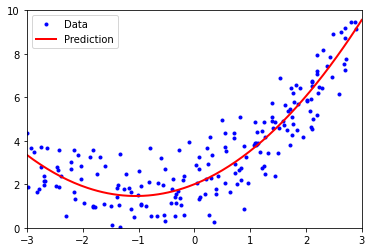

In [9]:
# Plot data and model prediction
plt.plot(x_quad, y_quad, "b.", label="Data")
x_pred = np.linspace(-3, 3, m).reshape(m, 1)
x_pred_poly = poly_features.transform(x_pred)
y_pred = lr_model_poly.predict(x_pred_poly)
plt.plot(x_pred, y_pred, "r-", linewidth=2, label="Prediction")
plt.axis([-3, 3, 0, 10])
plt.legend()
plt.show()

## Regularization

### General idea

- Solution against overfitting: constraining model parameters.

- *Ridge regression* (using l2 norm): 

$$\mathcal{L}(\pmb{\theta}) = \mathrm{MSE}(\pmb{\theta}) + \frac{\lambda}{2}\sum_{i=1}^n \theta_i^2$$

- *Lasso regression* (using l1 norm):

$$\mathcal{L}(\pmb{\theta}) = \mathrm{MSE}(\pmb{\theta}) + \lambda\sum_{i=1}^n |\theta_i|$$

- $\lambda$ is called the **regularization rate**.

### Example: observing the effects of regularization rate

(Heavily inspired by Chapter 4 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

In [ ]:
m = 20
x_reg = 3 * np.random.rand(m, 1)
y_reg = 1 + 0.5 * x_reg + np.random.randn(m, 1) / 1.5
x_new = np.linspace(0, 3, 100).reshape(100, 1)

In [ ]:
def plot_model(model_class, polynomial, lambdas, **model_kargs):
    for reg_rate, style in zip(lambdas, ("b-", "g--", "r:")):
        model = model_class(reg_rate, **model_kargs) if reg_rate > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(x_reg, y_reg)
        y_new_regul = model.predict(x_new)
        lw = 2 if reg_rate > 0 else 1
        plt.plot(x_new, y_new_regul, style, linewidth=lw, label=r"$\lambda = {}$".format(reg_rate))
    plt.plot(x_reg, y_reg, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x$", fontsize=18)
    plt.axis([0, 3, 0, 4])

In [ ]:
# Plot data and predictions with varying regularization rates
plt.figure(figsize=(14,7))
plt.subplot(121)
plot_model(Ridge, polynomial=False, lambdas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.title("Linear regression with Ridge regularization", fontsize=16)
plt.subplot(122)
plot_model(Ridge, polynomial=True, lambdas=(0, 10**-5, 1), random_state=42)
plt.title("Polynomial regression with Ridge regularization", fontsize=16)
plt.show()